# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# Create training set and define training dataloader
from torchvision import datasets
from torch.utils.data import DataLoader


c10_train_dataset = datasets.CIFAR10('data', train=True, download=True, transform=train_transforms)

# Batch size for training and testing and number of workers for the dataloader
b_size=128
n_workers = 10
valid_size_pc = 0.8

# # We split the training dataset for training and validation 
train_size = int(valid_size_pc * len(c10_train_dataset))
valid_size = len(c10_train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(c10_train_dataset, [train_size, valid_size])

trainloader = DataLoader(train_dataset, batch_size=b_size, num_workers=n_workers)
validloader = DataLoader(valid_dataset, batch_size=b_size, num_workers=n_workers)


# Create test set and define test dataloader
test_dataset = datasets.CIFAR10('data', train=False, download=True, transform=test_transforms)
testloader = DataLoader(test_dataset, batch_size=b_size, num_workers=n_workers)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):        
        print(classes[labels[i]])
        plt.rcParams["figure.figsize"] = [2, 2]
        image = images[i] / 2 + 0.5
        image = image.numpy()
        plt.imshow(image.T)
        plt.autoscale(False)
        plt.show()

deer


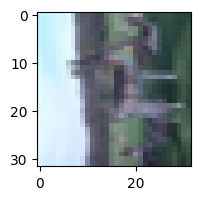

cat


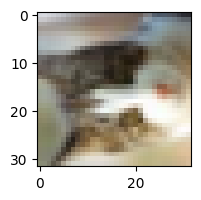

car


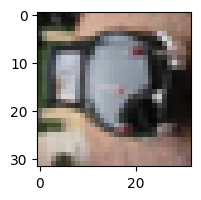

frog


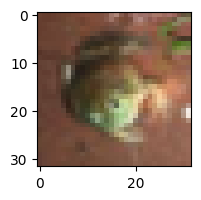

horse


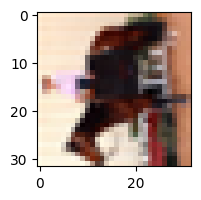

In [4]:
# Explore data
show5(trainloader)

car


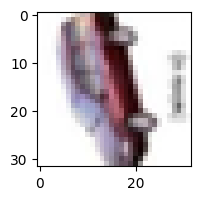

horse


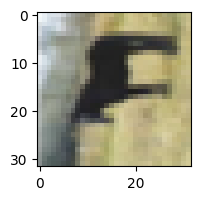

horse


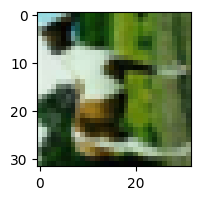

frog


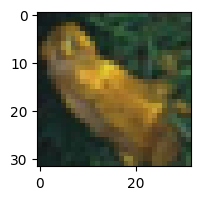

frog


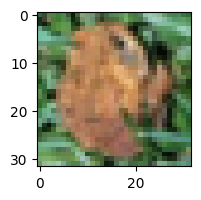

In [5]:
show5(validloader)

deer


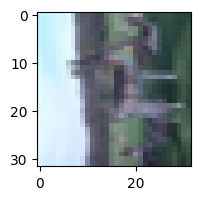

cat


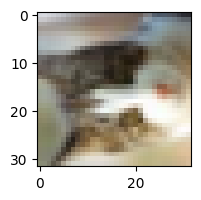

car


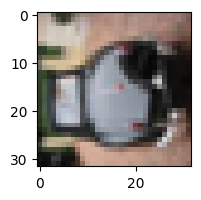

frog


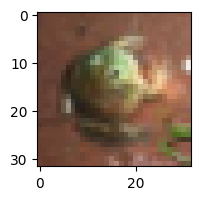

horse


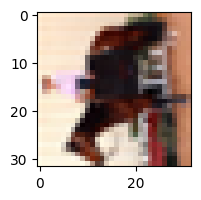

In [6]:
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [66]:
# We are going to construct a Convolutional Neural Network that have been designed 
# to work with images or data that has several dimensions
class C10CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Our network will have 5 cnn layers with kernel = 3, stride = 1, padding = 1
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1) 
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2,2)

        # The network will have 3 fully connected layers. Last cnn layer has 256 features
        # and MaxPool halved the image 2 times, so the dimension is 8 x 8, and it outputs
        # 256 * 8 * 8 features to the fc layer
        self.fc1 = nn.Linear(256*8*8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # We define the dropout for the fully connected layers
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        # We define how the network move and we use relu for activation and softmax for the output
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        # x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [67]:
# Create the classifier
model = C10CNNClassifier()

# We are using Negative Log-Likelihood Loss Function and the Adam optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [68]:
import time

#Train the network and see test acurracy


# If cuda or mps is available, use that device
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Load model in Device
model.to(device)

# Variables to track execution time
start_time = time.time()

# Define tracking variables
rloss_history = []
vloss_history = []
vacc_history = []

# Number of epochs
epochs = 30


for epoch in range(epochs):
    steps = 0
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Reset gradients
        
        output = model.forward(inputs)
        # output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Store the running loss
    rloss_history.append(running_loss/len(trainloader))
    
    # Validation step
    model.eval() # Put model in evaluation mode
    
    valid_loss = 0
    accuracy = 0
    
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            
            # Calculate accuracy with validation dataset
            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equality = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
    # Restart training mode
    model.train()
    
    # Print metrics of the epoch
    print(f"Epoch {epoch+1}/{epochs}: "
          f"TR loss: {running_loss/len(trainloader):.3f} | "
          f"V loss: {valid_loss/len(validloader):.3f} | "
          f"V Acc: {accuracy/len(validloader):.3f}")

    # Reset running loss for next epoch
    running_loss = 0

    # Store Validation Loss and Accuracy for further investigation
    vloss_history.append(valid_loss/len(validloader))
    vacc_history.append(accuracy/len(validloader))

print(f"\nTraining Finished | Epochs {epochs} | Total Time: {(time.time() - start_time):.2f} sec")

Epoch 1/30: TR loss: 1.520 | V loss: 1.162 | V Acc: 0.583
Epoch 2/30: TR loss: 1.021 | V loss: 0.967 | V Acc: 0.658
Epoch 3/30: TR loss: 0.789 | V loss: 0.866 | V Acc: 0.700
Epoch 4/30: TR loss: 0.638 | V loss: 0.756 | V Acc: 0.747
Epoch 5/30: TR loss: 0.528 | V loss: 0.774 | V Acc: 0.758
Epoch 6/30: TR loss: 0.432 | V loss: 0.740 | V Acc: 0.770
Epoch 7/30: TR loss: 0.355 | V loss: 0.786 | V Acc: 0.767
Epoch 8/30: TR loss: 0.291 | V loss: 0.878 | V Acc: 0.752
Epoch 9/30: TR loss: 0.237 | V loss: 0.876 | V Acc: 0.774
Epoch 10/30: TR loss: 0.199 | V loss: 0.922 | V Acc: 0.776
Epoch 11/30: TR loss: 0.177 | V loss: 0.985 | V Acc: 0.768
Epoch 12/30: TR loss: 0.145 | V loss: 0.992 | V Acc: 0.782
Epoch 13/30: TR loss: 0.119 | V loss: 0.933 | V Acc: 0.785
Epoch 14/30: TR loss: 0.096 | V loss: 1.029 | V Acc: 0.784
Epoch 15/30: TR loss: 0.087 | V loss: 1.013 | V Acc: 0.782
Epoch 16/30: TR loss: 0.081 | V loss: 1.106 | V Acc: 0.787
Epoch 17/30: TR loss: 0.080 | V loss: 1.116 | V Acc: 0.787
Epoch 

Plot the training loss (and validation loss/accuracy, if recorded).

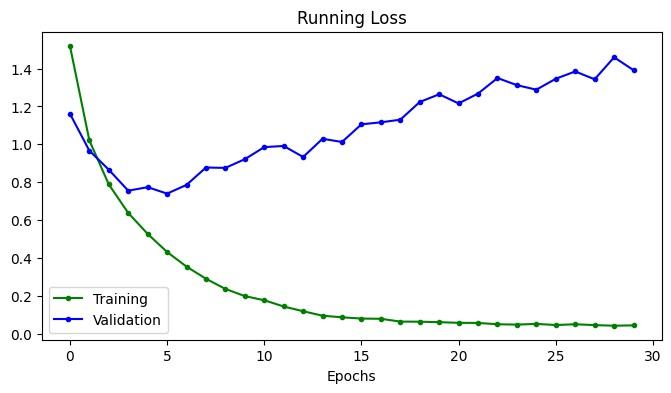

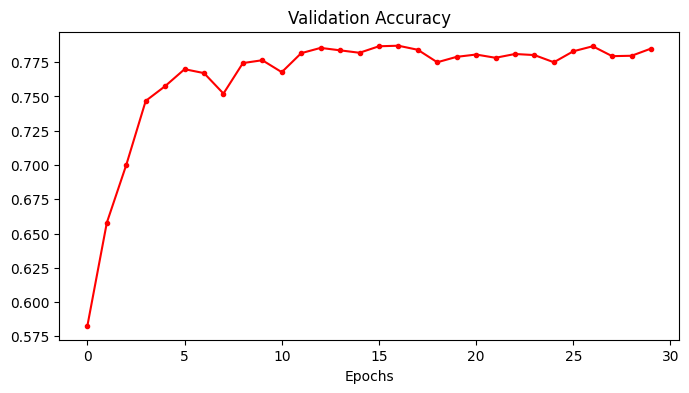

In [69]:
## YOUR CODE HERE ##
plt.figure(figsize=(8,4))
plt.plot(rloss_history, '-g.')
plt.plot(vloss_history, '-b.')
plt.title('Running Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'])
plt.show()

plt.figure(figsize=(8,4))
plt.plot(vacc_history, '-r.')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [21]:
# Variables to track accuracy
accuracy = 0
test_loss = 0
 # Setup model in evaluation mode

with torch.no_grad():
    model.eval()
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
     
        outputs = model.forward(inputs)
        test_loss += criterion(outputs, labels)
        
        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
        
print(f'Test accuracy: {100 * accuracy/len(testloader):.2f}%')

Test accuracy: 78.59%


## Saving your model
Using `torch.save`, save your model for future loading.

In [107]:
## YOUR CODE HERE ##

torch.save(model, 'C10CNNClassifier_model.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.



**Recommendations**

We achieved 78% of accuracy with out custom model using a Convolutional Neural Network. I beleive that using a cnn, this is the maximum accuracy we can get, as the Training Loss/Validation Loss graph shows that the model is overfitting. We tested with other hyperparameters and optimizers, and this was the best result using this type of NN.

However, we didn't explore other avanced networks like ResNet that have showed to be very good for this kind of tasks.

I suggest to keep exploring other network types or to implement transfer learning.
